In [2]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine


In [3]:
import pandas as pd
from sqlalchemy import create_engine


In [4]:
df_raw = pd.read_csv(r"C:\Users\mukhe\OneDrive\Desktop\coding\ecommerce\data\raw\online_retail_II.csv", encoding='latin1')


In [5]:
df_raw.head()


,ï»¿Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [6]:
user = 'root'         # your MySQL username
password = 'name'     # your MySQL password
host = 'localhost'    # usually localhost
database = 'predictive_db'   # name of your database

# Create SQLAlchemy engine
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")


In [7]:
df_raw.to_sql('online_retail', con=engine, if_exists='replace', index=False)


541910

In [8]:
# Check column data types
df_raw.dtypes


ï»¿Invoice      object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [9]:
# Check missing values
df_raw.isnull().sum()


ï»¿Invoice          0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [10]:
pd.read_sql("SELECT * FROM online_retail", con=engine) 

,ï»¿Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


In [11]:
#Check missingness:
missing = df_raw.isna().sum().sort_values(ascending=False)
missing[missing>0]


Customer ID    135080
Description      1454
dtype: int64

In [12]:
df = df_raw


In [13]:
#Check duplicates:
df.duplicated().sum()
df[df.duplicated(keep=False)].head()

,ï»¿Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,01-12-2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,01-12-2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,01-12-2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,01-12-2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,01-12-2010 11:45,2.95,17908.0,United Kingdom


In [14]:
df.rename(columns={'ï»¿Invoice': 'Invoice'}, inplace=True)

In [15]:
# ensure date column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce', dayfirst=False)

# convert numeric columns
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').astype('Int64')  # nullable int
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Customer ID'] = df['Customer ID'].astype(str).str.strip()

# 1) Drop rows with no customer id if CustomerID is essential
df = df.dropna(subset=['Customer ID'])
df = df.dropna(subset=['Country'])

# 2) For description text, fill NAs with empty string
df['Description'] = df['Description'].fillna('')
df = df.dropna(subset=['Invoice'])
df = df.dropna(subset=['StockCode'])
df = df.dropna(subset=['Quantity'])

# 3) For numeric columns, consider imputing or dropping:
df['Price'] = df['Price'].fillna(0)   # careful — document this choice
# or use median
# df['unit_price'] = df['unit_price'].fillna(df['unit_price'].median())
df = df.dropna(subset=['InvoiceDate'])

# separate returns/refunds first if they are encoded, e.g., InvoiceNo starts with 'C'
refunds = df[df['Invoice'].str.contains('C', na=False)]
sales = df[~df['Invoice'].str.contains('C', na=False)]

# drop zero/negative unit_price or quantity for sales
sales = sales[(sales['Quantity'] > 0) & (sales['Price'] > 0)]

# combine back if needed
df_clean = pd.concat([sales, refunds], ignore_index=True)

from scipy.stats.mstats import winsorize
# or simple clip at percentiles:
q_low, q_high = df_clean['Price'].quantile([0.01, 0.99])
df_clean['Price'] = df_clean['Price'].clip(lower=q_low, upper=q_high)

In [16]:
df_clean['total_price'] = df_clean['Quantity'] * df_clean['Price']

In [17]:
import datetime as dt
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'total_price': lambda x: x.sum()
}).rename(columns={'InvoiceDate':'recency', 'Invoice':'frequency', 'total_price':'monetary'})


In [18]:
# simple CLV = avg_order_value * purchase_frequency * expected_customer_lifespan
avg_order = rfm['monetary'] / rfm['frequency']
purchase_freq = rfm['frequency'] / ( (df_clean['InvoiceDate'].max() - df_clean['InvoiceDate'].min()).days/30 ) # per month
rfm['clv_simple'] = avg_order * purchase_freq * 12  # 12 months life assumption


In [19]:
# remove exact duplicate rows
df_clean = df_clean.drop_duplicates()

# remove rows you don't want (e.g., products with no description + zero price)
df_clean = df_clean[~((df_clean['Description']=='') & (df_clean['Price']==0))]


In [20]:
print("Rows before:", df.shape[0])
print("Rows after:", df_clean.shape[0])
df_clean[['Quantity','Price','total_price']].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])


Rows before: 232960
Rows after: 229594


,Quantity,Price,total_price
count,229594.0,229594.000000,229594.0
mean,9.803488,3.257435,18.239786
std,242.905526,3.245358,501.607342
min,-80995.0,0.290000,-168469.6
1%,-2.0,0.290000,-7.8
5%,1.0,0.420000,0.85
25%,1.0,1.250000,3.75
50%,3.0,2.100000,9.84
75%,10.0,4.130000,17.34
95%,25.0,9.950000,55.8


In [21]:
import os
import pandas as pd

# Full path (with filename)
DATA_CLEAN = r"C:\Users\mukhe\OneDrive\Desktop\coding\ecommerce\data\OnlineRetail_clean.csv"

# Ensure folder exists
os.makedirs(os.path.dirname(DATA_CLEAN), exist_ok=True)

# Save the cleaned DataFrame
df_clean.to_csv(DATA_CLEAN, index=False, encoding='utf-8')

print("✅ Cleaned data saved successfully at:", DATA_CLEAN)


✅ Cleaned data saved successfully at: C:\Users\mukhe\OneDrive\Desktop\coding\ecommerce\data\OnlineRetail_clean.csv


In [23]:
df_clean.to_sql('OnlineRetail_clean', con=engine, if_exists='replace', index=False)
print("✅ Cleaned data uploaded successfully!")


✅ Cleaned data uploaded successfully!


C:\Users\mukhe\AppData\Local\Temp\ipykernel_9372\2290641228.py:1: UserWarning: The provided table name 'OnlineRetail_clean' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  df_clean.to_sql('OnlineRetail_clean', con=engine, if_exists='replace', index=False)


In [24]:
# basics
print("shape:", df.shape)
display(df.dtypes)
df.describe(include='all').T.head(20)


shape: (232960, 8)


Invoice                object
StockCode              object
Description            object
Quantity                Int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Invoice,232960,11139,581219,749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,232960,3858,85123A,1018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,232960,3963,WHITE HANGING HEART T-LIGHT HOLDER,1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,232960.0,<NA>,<NA>,<NA>,9.409499,-80995.0,1.0,3.0,10.0,80995.0,242.463311
InvoiceDate,232960,NaN,NaN,NaN,2011-05-14 03:15:05.540521984,2010-01-12 08:26:00,2011-03-04 11:36:00,2011-06-09 10:46:00,2011-09-06 10:46:00,2011-12-10 17:19:00,NaN
Price,232960.0,NaN,NaN,NaN,4.886848,-11062.06,1.25,2.1,4.13,38970.0,135.139366
Customer ID,232960,3126,nan,60177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,232960,35,United Kingdom,213592,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df.isna().sum().sort_values(ascending=False).head(10)
for col in ['Customer ID','Description','Country']:
    print(col, "->", df[col].nunique())


Customer ID -> 3126
Description -> 3963
Country -> 35


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
df['total_price'] = df['Quantity'] * df['Price']

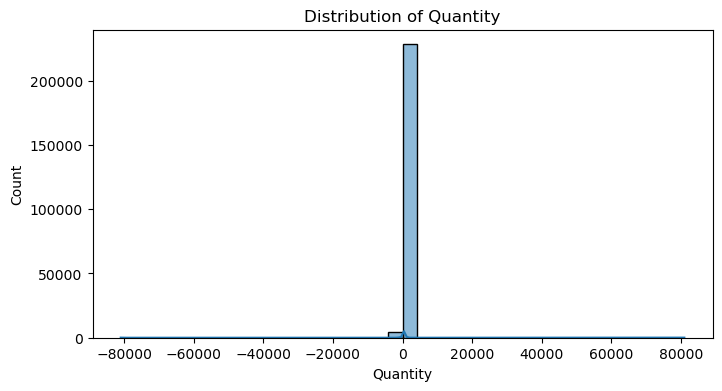

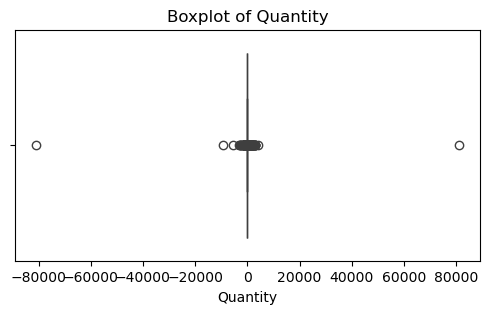

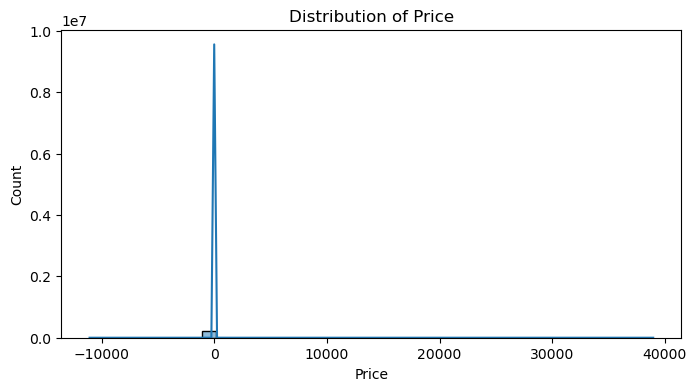

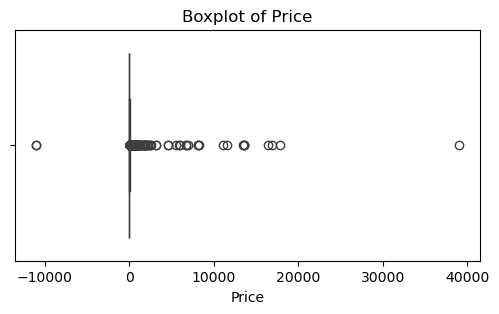

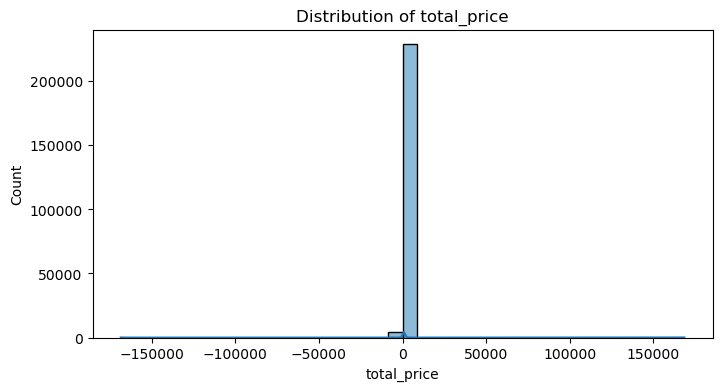

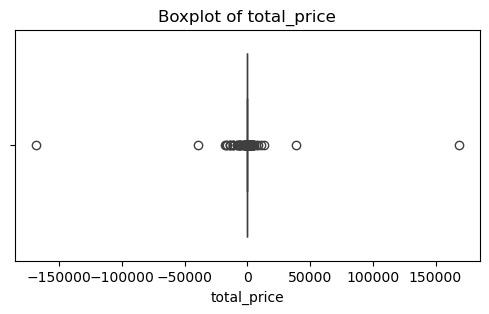

In [28]:
numeric_cols = ['Quantity','Price','total_price']  # ensure total_price exists
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), bins=40, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.show()


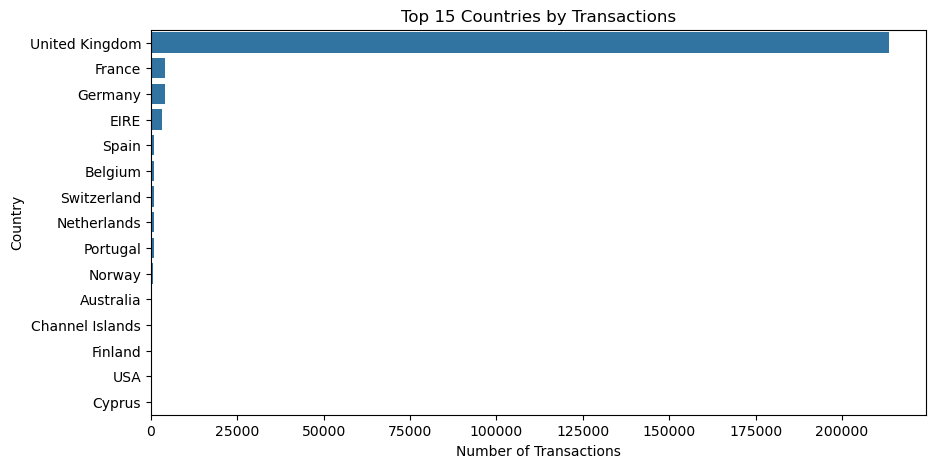

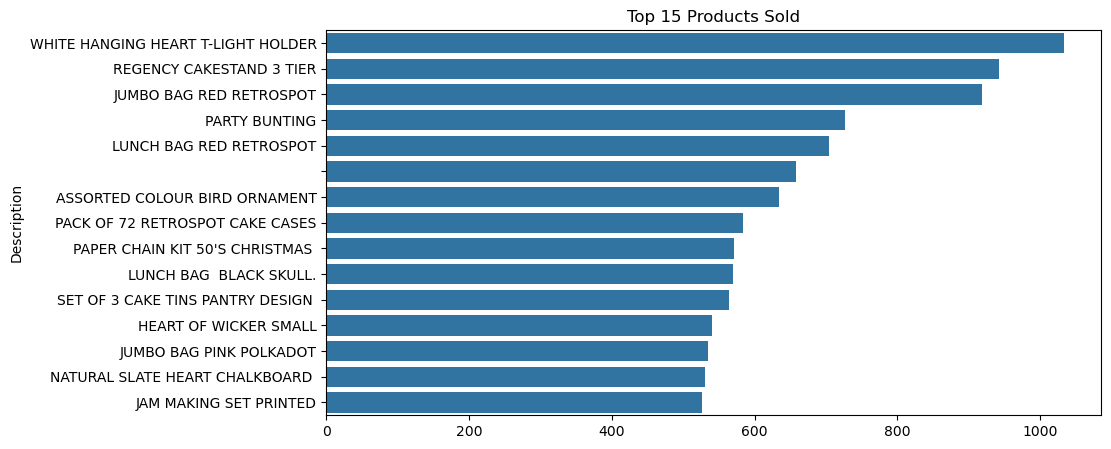

In [30]:
# top countries
top_countries = df['Country'].value_counts().nlargest(15)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 15 Countries by Transactions")
plt.xlabel("Number of Transactions")
plt.show()

# top products
top_products = df['Description'].value_counts().nlargest(15)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 15 Products Sold")
plt.show()


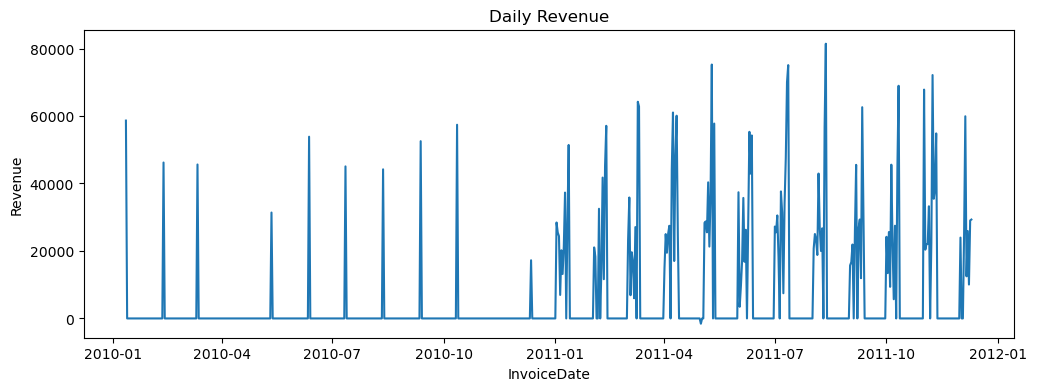

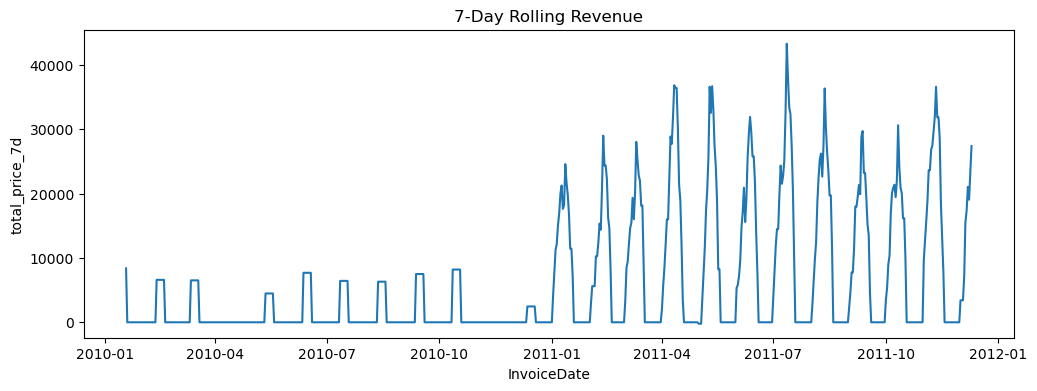

In [31]:
# ensure datetime index
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate', inplace=False)

# daily revenue
daily = df.resample('D', on='InvoiceDate').agg({'total_price':'sum', 'Invoice':'nunique'}).rename(columns={'Invoice':'n_orders'})
daily = daily.fillna(0)

plt.figure(figsize=(12,4))
sns.lineplot(data=daily['total_price'])
plt.title('Daily Revenue')
plt.ylabel('Revenue')
plt.show()

# weekly rolling
daily['total_price_7d'] = daily['total_price'].rolling(7).mean()
plt.figure(figsize=(12,4))
sns.lineplot(data=daily['total_price_7d'])
plt.title('7-Day Rolling Revenue')
plt.show()


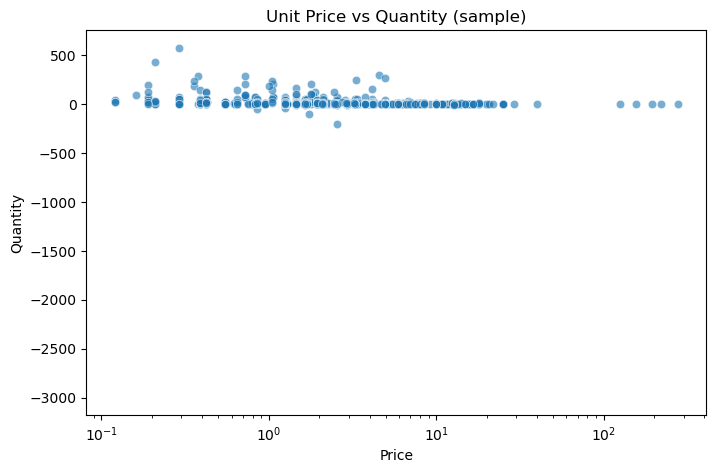

In [32]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Price', y='Quantity', data=df.sample(2000), alpha=0.6)
plt.xscale('log')
plt.title('Unit Price vs Quantity (sample)')
plt.show()


In [35]:
import plotly.express as px


In [36]:
country_agg = df.groupby('Country').agg(total_revenue=('total_price','sum'), avg_order=('total_price','mean'), n_orders=('Invoice','nunique')).reset_index()
country_agg = country_agg.sort_values('total_revenue', ascending=False).head(12)
fig = px.bar(country_agg, x='Country', y='total_revenue', hover_data=['avg_order','n_orders'], title='Top Countries by Revenue')
fig.show()


In [37]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [38]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [39]:
rfm = df.groupby('Customer ID').agg(
    recency = ('InvoiceDate', lambda x: (reference_date - x.max()).days),
    frequency = ('Invoice', 'nunique'),
    monetary = ('total_price', 'sum')
).reset_index()

In [40]:
rfm['clv_simple'] = rfm['monetary'] * rfm['frequency']

In [41]:
rfm.to_sql('rfm_customers', con=engine, if_exists='replace', index=False)


3126

In [42]:
df = df.merge(rfm, on='Customer ID', how='left')


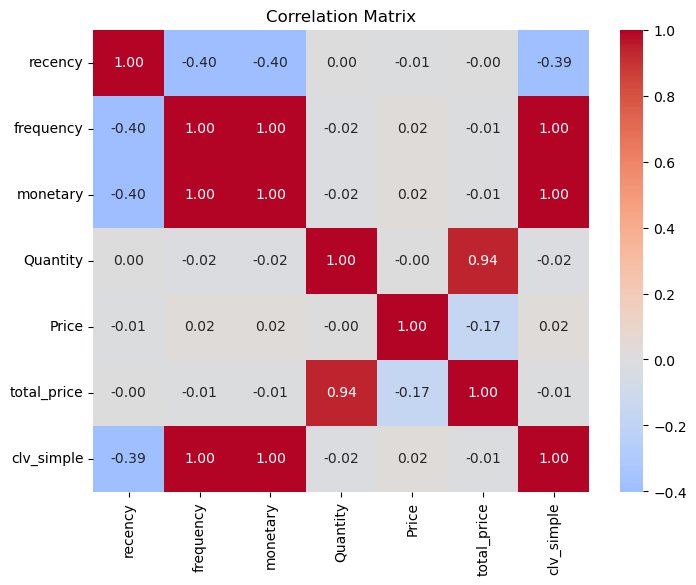

In [43]:
num = ['recency','frequency','monetary','Quantity','Price','total_price','clv_simple']  # include fields you created
corr = df[num].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


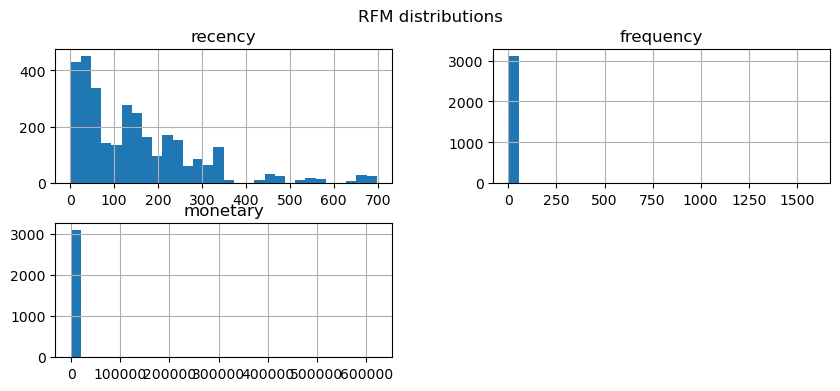

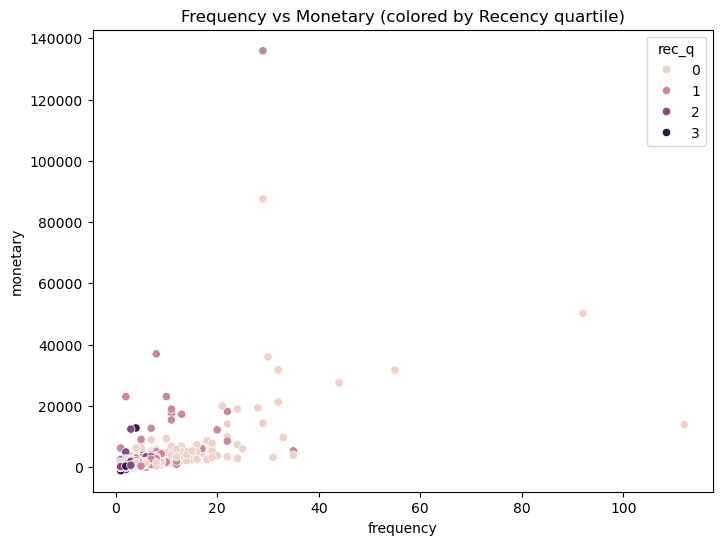

In [44]:
# rfm is a DataFrame aggregated by customerid
rfm = pd.read_sql('SELECT * FROM rfm_customers', engine)
# quick histograms
rfm[['recency','frequency','monetary']].hist(bins=30, figsize=(10,4))
plt.suptitle('RFM distributions')
plt.show()

# scatter: monetary vs frequency colored by recency quartile
rfm['rec_q'] = pd.qcut(rfm['recency'], 4, labels=False)
plt.figure(figsize=(8,6))
sns.scatterplot(x='frequency', y='monetary', hue='rec_q', data=rfm.sample(2000))
plt.title('Frequency vs Monetary (colored by Recency quartile)')
plt.show()


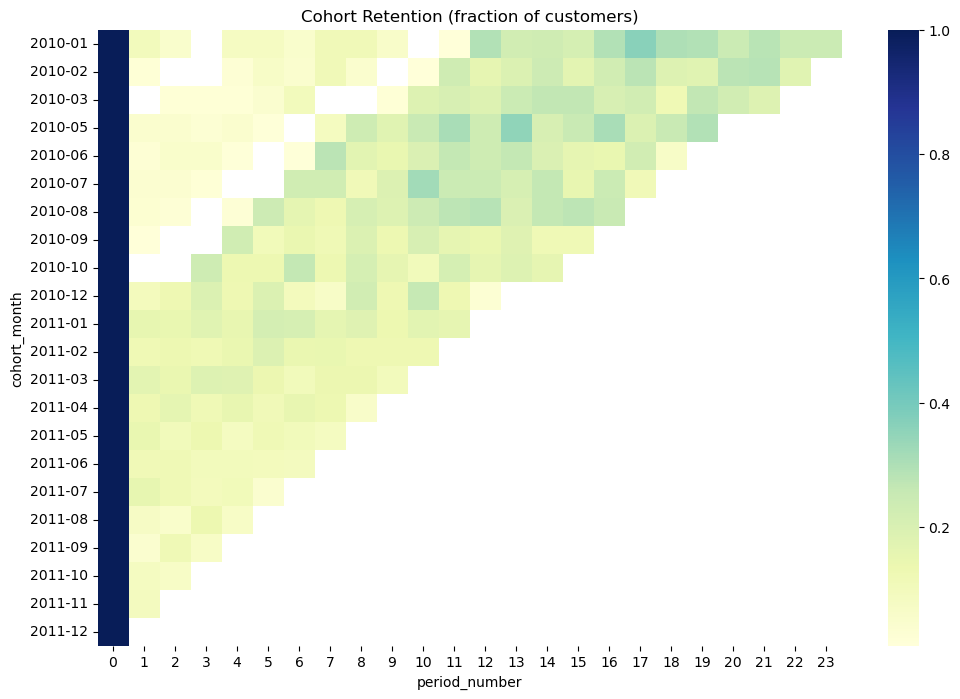

In [45]:
df_cohort = df.copy()
df_cohort['order_month'] = df_cohort['InvoiceDate'].dt.to_period('M')
df_cohort['cohort_month'] = df_cohort.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')
cohort = df_cohort.groupby(['cohort_month','order_month']).agg(n_customers=('Customer ID','nunique')).reset_index()
cohort['period_number'] = (cohort['order_month'] - cohort['cohort_month']).apply(lambda x: x.n)
cohort_pivot = cohort.pivot(index='cohort_month', columns='period_number', values='n_customers')
cohort_retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

plt.figure(figsize=(12,8))
sns.heatmap(cohort_retention, annot=False, cmap='YlGnBu')
plt.title('Cohort Retention (fraction of customers)')
plt.show()


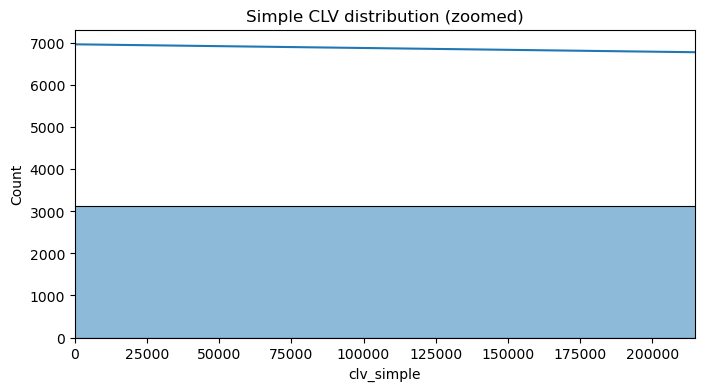

In [46]:
plt.figure(figsize=(8,4))
sns.histplot(rfm['clv_simple'].dropna(), bins=50, kde=True)
plt.xlim(0, rfm['clv_simple'].quantile(0.99))  # zoom to 99th percentile
plt.title('Simple CLV distribution (zoomed)')
plt.show()


In [47]:
fig = px.line(daily.reset_index(), x='InvoiceDate', y='total_price', title='Daily Revenue (interactive)')
fig.show()

fig2 = px.scatter(df.sample(2000), x='Price', y='total_price', color='Country', hover_data=['Description'])
fig2.show()


In [48]:
df.columns


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'total_price', 'recency',
       'frequency', 'monetary', 'clv_simple'],
      dtype='object')

## top insights
  #### 1.Top 3 countries generate: 90.43% of total revenue.
  #### 2.Peak revenue day: Tuesday
  #### 3.Top 5 products contribute: 7.15% of total sales.
  #### 4. Percentage of high-value customers: 20.03%
   ####   High-value customers contribute: 75.66% of revenue
####   5. Average retention after Month 1: 8.68% 
   ####   Drop after Month 1: 91.32%

In [7]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\mukhe\OneDrive\Desktop\coding\ecommerce\ecom\data\features\customer_features.csv",
    
)


In [8]:
df.columns


Index(['Customer ID', 'recency_days', 'frequency', 'monetary', 'aov',
       'avg_days_between', 'tenure_days', 'clv_simple_predict', 'spend_30d',
       'spend_90d', 'spend_365d', 'r_score', 'f_score', 'm_score', 'rfm_sum',
       'rfm_score', 'segment'],
      dtype='object')